### Estimating breeding and aestivating sizes for Lehmann et al. (2017) dataset
#### Mwima, Hui, Kayondo, Burt (2024) in prep. 
#### email <tin-yu.hui11@imperial.ac.uk>

#### 1. Load dataset, plot seasonality
We had reformatted the original genotypic dataset from Lehmann et al. (2017), from which the *An. coluzzii* temporal samples from Thierola, Mali, are of our interest. We load the dataset, then plot the seasonalities of the samples. The original authors assumed DS is from May to December. 

In [1]:
# LOAD PACKAGES
require(compiler)
require(doParallel)
require(inline)

Loading required package: compiler
Loading required package: doParallel
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: inline


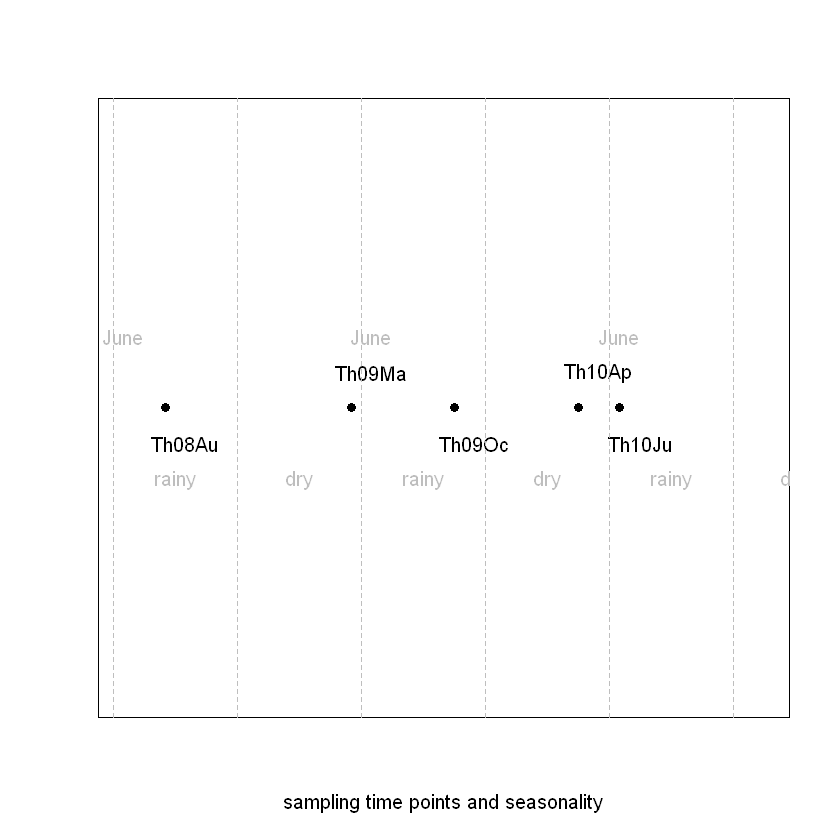

In [2]:
# READ THE REFORMATTED LEHMANN csv 
dat<-read.csv('Lehmann_coded_tinyu.csv', header=T, stringsAsFactors=F)

# THE 7 THIEROLA TEMPORAL SAMPLES IN CHRONOLOGICAL ORDER. ONLY 5 ARE USED HERE
# Th=THIEROLA, 08=YEAR, Au=MONTH
PoD<-c('Th08Au', 'Th09Ma', 'Th09Oc', 'Th10Ja', 'Th10Ap', 'Th10Ju', 'Th10Au')
col<-c(1, 1, 1, NA, 1, 1, NA)

# CREATE A VECTOR TO SHOW THE RELATIVE TIME (IN GENERATIONS) AMONG THESE 7 TIME POINTS
# Th08Au IS CONSIDERED AS THE 0th MONTH OF THE SAMPLE, SO THE NEXT SAMPLE IS IN 9 MONTHS' TIME. 
t<-c(0, 9, 14, 17, 20, 22, 24)

# WORK OUT ALL ALLELE FREQ PER POPULATION
# AND ALSO EFFECT SAMPLE SIZE PER LOCUS PER POPULATION
# 7 ROWS, 738 COLUMNS
all_allele_freq<-matrix(nr=length(PoD), nc=ncol(dat)-4)
all_eff_s<-all_allele_freq
for (i in 1:length(PoD))
{
    sample<-dat[dat$PoD==PoD[i], 5:ncol(dat)]
    all_allele_freq[i,]<-apply(sample, 2, function(x) {mean(x, na.rm=T)/2})
    all_eff_s[i,]<-apply(sample, 2, function(x) {sum(!is.na(x))})
}

# PLOT THE SEASONAILTIES, DEC TO MAY ARE DS
plot(y=rep(1, length(t)), x=t+27, 
    xlab='sampling time points and seasonality', ylab='', 
    xlim=c(25, 56), pch=16, col=col, yaxt='n', xaxt='n')
text(y=1+0.05*(-1)^(1:length(t[c(-4, -7)])), x=t[c(-4, -7)]+28, labels=PoD[c(-4,-7)])
temp<-c(6.5, 12.5)
temp<-c(temp, temp+12, temp+24, temp+36, temp+48, temp+60)
abline(v=temp, col='grey', lty=2)
text(y=rep(0.9, length(temp)), x=temp-3, label=rep(c('rainy', 'dry'), length(temp)/2), col='grey')
text(y=rep(1.1, 4), x=seq(1, 61, 12), label=rep('June', 5), col='grey')
rm(temp)

#### 2. The first year: 2008-2009
##### 2.1 The observed data
Three temporal samples are involved (Th08Au, Th09Ma, Th09Oc) in the estimation of the breeding and aestivating sizes for the first year. 

First the allele frequencies from each temporal sample are extracted, and so are the effective sample sizes per locus (to account for missing genotypes). Then the pooled allele frequencies are calculated for minor allele frqeuency cut-off. Only loci with pooled maf>=0.05 are included in the estimation. Pairwise temporal F's are computed, via Fc (see SI), and are our summary statistics (SS) 

In [14]:
# YEAR 1, Th08Au, Th09Ma, Th09Oc
# EXTRACT THE THREE ALLELE FREQ
p1<-all_allele_freq[1,]
p2<-all_allele_freq[2,]
p3<-all_allele_freq[3,]
# THE THREE EFFECTIVE SAMPLE SIZE PER LOCUS
eff_s1<-all_eff_s[1,]
eff_s2<-all_eff_s[2,]
eff_s3<-all_eff_s[3,]
# POOLED ALLELE FREQ, WEIGHTED BY EFFECTIVE SAMPLE SIZES
p<-(p1*eff_s1+p2*eff_s2+p3*eff_s3)/(eff_s1+eff_s2+eff_s3)
# MAF CUTOFF ON  THE POOLED ALLELE FREQ
temp<-(p>=0.05) & (p<=0.95)
# NUMBER OF LOCI
K<-sum(temp)
K
# SUBSET
p1<-p1[temp]
p2<-p2[temp]
p3<-p3[temp]
eff_s1<-eff_s1[temp]
eff_s2<-eff_s2[temp]
eff_s3<-eff_s3[temp]
# THE F STATISTIC, Fc
obs_F21<-mean((p1-p2)^2/((p1+p2)/2-p1*p2)-0.5/eff_s1-0.5/eff_s2, na.rm=T)
obs_F32<-mean((p3-p2)^2/((p3+p2)/2-p3*p2)-0.5/eff_s3-0.5/eff_s2, na.rm=T)
obs_F31<-mean((p3-p1)^2/((p3+p1)/2-p3*p1)-0.5/eff_s3-0.5/eff_s1, na.rm=T)
c(obs_F21, obs_F32, obs_F31)

[1] 555

[1] 0.07143989 0.06686830 0.02895323

The three temporal Fc's are displayed here from 540 loci. These are our real SS, observation. 

##### 2.2 ABC parameter estimation
Then we run ABC to find the best sets of sizes that yield our observed SS. The priors and procedures are described in the publication. 2 million sets of priors are used, and the best 1000 are selected as posterior. 

Note that the stochastic nature of ABC means we will get a slightly different set of results every time, but the average should be very close to what we published in the main text. 

Some further technical details: We run the 2 million of ABC in parallel chuncks, which means we need to accept and return the best 1000 from each chunck, then choose the global best 1000 from within. The generations of random numbers are handled by the R parellel package. 

In [4]:
# THE SIMULATOR
body<-"
	GetRNGstate();
	double *h_rep_N=REAL(rep_N); double *h_denom_N=REAL(denom_N);
	int *h_aes=INTEGER(aes); double *h_aes_return=REAL(aes_return);
	int h_K=asInteger(K); double h_N_a=asReal(N_a);
	int t=LENGTH(rep_N);
	// THE ALLELE FREQ MATRIX FOR BREEDING
	SEXP p_rep=PROTECT(allocMatrix(REALSXP, h_K, t+1));
	double *h_p_rep=REAL(p_rep);
	// VECTOR TO AESTIVATING
	SEXP p_aes=PROTECT(allocVector(REALSXP, h_K));
	double *h_p_aes=REAL(p_aes);
	// INITIALISE
	for (int i=0; i<h_K; i++)
	{
		h_p_rep[i]=runif(0.2, 0.8);
		h_p_aes[i]=0;
	}
	// PROPAGATE
	int offset=0; int offset_parent=0;
	for (int i=0; i<t; i++)
	{
		offset=(i+1)*h_K; offset_parent=i*h_K;
		for (int j=0; j<h_K; j++)
		{
			h_p_rep[offset+j]=(rbinom(2*h_rep_N[i], h_p_rep[offset_parent+j])+h_aes_return[i]*h_p_aes[j])/(2*h_denom_N[i]);
			if (h_aes[i]==1)
			{
				h_p_aes[j]=rbinom(2*h_N_a, h_p_rep[offset_parent+j]);
			}
		}
	}
	PutRNGstate();
	UNPROTECT(2);
	return p_rep;
"
includes<-"
#include <R.h>
#include <Rdefines.h>
#include <Rinternals.h>
#include <Rmath.h>
"
quick_aestivation_sim_c<-cfunction(sig=c(rep_N='array', denom_N='array', aes='array', 
                                         aes_return='array', N_a='numeric', K='integer'), 
                          body=body, includes=includes, 
                          language='C', convention='.Call')

quick_aestivation_sim2<-function(N_r=5000, N_d=500, N_a=1000, t_r=6, t_d=6, years=5, K=500, starting_month=6)
{
    # EXPAND BREEDING SIZES
    rep_N<-rep(c(N_r-N_a, rep(N_r, t_r-1), rep(N_d, t_d)), years)
    rep_N[1]<-N_r
    t<-length(rep_N)
    denom_N<-rep(c(rep(N_r, t_r), rep(N_d, t_d)), years)
    # TRANSITION, -1 MEANS FROM DS TO RS. +1 RS TO DS
    aes<-rep(c(rep(0, t_r), 1, rep(0, t_d-1)), years)
    aes_return<-rep(c(1, rep(0, t_r+t_d-1)), years)
    aes_return[1]<-0
    # RUN
    p_rep<-quick_aestivation_sim_c(rep_N, denom_N, as.integer(aes), aes_return, N_a, as.integer(K))
    return(p_rep)
}
quick_aestivation_sim2<-cmpfun(quick_aestivation_sim2, 3)

In [5]:
# SAMPLE AT WHICH GENERATIONS. INCLUDE 24 GENS OF BURN-IN
t1<-t[1]+28
t2<-t[2]+28
t3<-t[3]+28
c(t1, t2, t3)

[1] 28 37 42

In [15]:
# ABC
cl<-makeCluster(47)
registerDoParallel(cl)
result_0809<-foreach(i=1:200, .combine='rbind', .packages='inline') %dopar%
{
    # BUILD cfunction
    quick_aestivation_sim_c<-cfunction(sig=c(rep_N='array', denom_N='array', aes='array', 
                                         aes_return='array', N_a='numeric', K='integer'), 
                          body=body, includes=includes, 
                          language='C', convention='.Call')
    # 50000 SIMS PER THREAD, RETURN TOP 1000
    k<-50000
    out<-1000
    # PRIOR
    prior_d<-round(runif(k, 10, 500))
    prior_r<-round(runif(k, prior_d+2, 10000))
    prior_a<-round(runif(k, 1, prior_r-prior_d))
    temp_result<-matrix(nc=3, nr=k)
    # ABC
    for (j in 1:k)
    {
        # SIM DATA
        temp<-quick_aestivation_sim2(N_r=prior_r[j], N_d=prior_d[j], N_a=prior_a[j], K=K)
        # SIM SAMPLING
        x1<-rbinom(K, size=2*eff_s1, prob=temp[,t1])/(2*eff_s1)
        x2<-rbinom(K, size=2*eff_s2, prob=temp[,t2])/(2*eff_s2)
        x3<-rbinom(K, size=2*eff_s3, prob=temp[,t3])/(2*eff_s3)
        # CALCULATE SS
        sim_F21<-mean((x2-x1)^2/((x1+x2)/2-x1*x2)-0.5/eff_s1-0.5/eff_s2, na.rm=T)
        sim_F32<-mean((x3-x2)^2/((x3+x2)/2-x3*x2)-0.5/eff_s3-0.5/eff_s2, na.rm=T)
        sim_F31<-mean((x3-x1)^2/((x3+x1)/2-x3*x1)-0.5/eff_s1-0.5/eff_s3, na.rm=T)
        temp_result[j,]<-c(sim_F21, sim_F32, sim_F31)
    }
    # CALCULATE DISTANCE
    distance<-sqrt((temp_result[,1]-obs_F21)^2+(temp_result[,2]-obs_F32)^2+(temp_result[,3]-obs_F31)^2)
    temp<-order(distance)[1:out]
    # SHORTLIST
    return(cbind(prior_r[temp], prior_d[temp], prior_a[temp], distance[temp]))
}
stopCluster(cl)
dim(result_0809)

[1] 200000      4

[1] 0.02184942

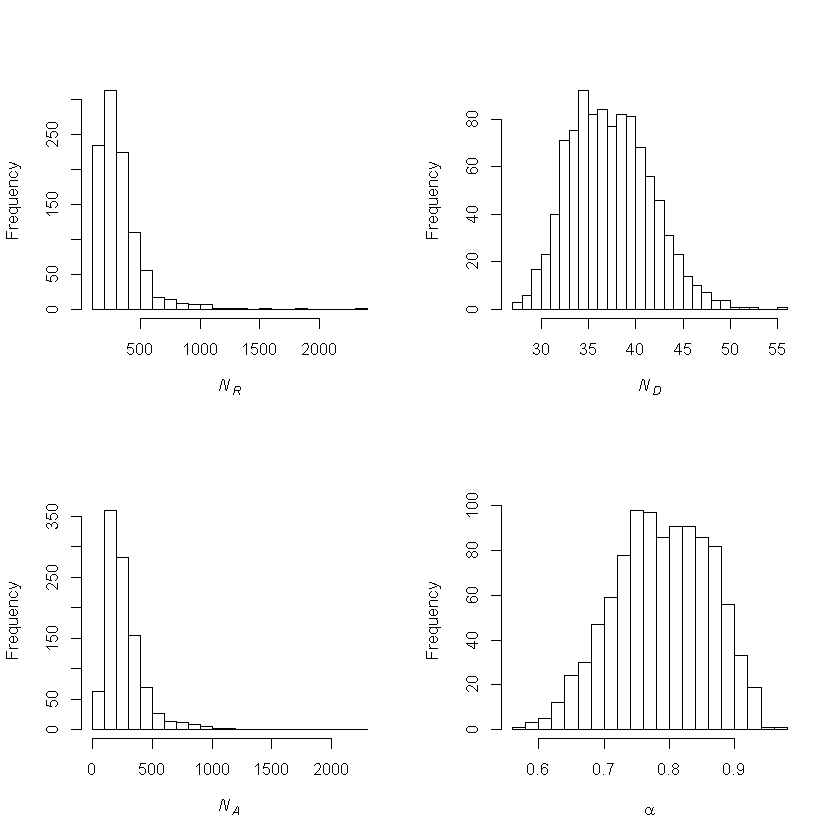

In [16]:
# THEN CALCULATE ANOTHER ROUND OF DISTANCE
temp<-order(result_0809[,4])[1:1000]
posterior_r<-result_0809[temp,1]
posterior_d<-result_0809[temp,2]
posterior_a<-result_0809[temp,3]
max(result_0809[temp,4]) # EPSILON

# POSTERIOR PLOTS
par(mfrow=c(2,2))
hist(posterior_r, breaks=25, xlab=expression(italic(N['R'])), main='')
hist(posterior_d, breaks=25, xlab=expression(italic(N['D'])), main='')
hist(posterior_a, breaks=25, xlab=expression(italic(N['A'])), main='')
hist(posterior_a/posterior_r, breaks=25, xlab=expression(italic(alpha)), main='')

In [17]:
# POSTERIOR N_R
median(posterior_r)
quantile(posterior_r, c(0.1, 0.9))

[1] 281.5

10% 90% 
159 524

In [18]:
# POSTERIOR N_D
median(posterior_d)
quantile(posterior_d, c(0.1, 0.9))

[1] 38

10% 90% 
 33  43

In [19]:
# POSTERIOR N_A
median(posterior_a)
quantile(posterior_a, c(0.1, 0.9))

[1] 222

10% 90% 
111 454

In [20]:
# POSTERIOR alpha
median(posterior_a/posterior_r)
quantile(posterior_a/posterior_r, c(0.1, 0.9))

[1] 0.789998

10%       90% 
0.6943176 0.8837999

#### 3. The second year: 2009-2010
##### 3.1 The observed data
With samples from Th09Oc, Th10Ap, Th10Ju. 

In [21]:
# SECOND YEAR: Th09Oc, Th10Ap, Th10Ju
# EXTRACT THE THREE ALLELE FREQ
p1<-all_allele_freq[3,]
p2<-all_allele_freq[5,]
p3<-all_allele_freq[6,]
# THE THREE EFFECTIVE SAMPLE SIZE PER LOCUS
eff_s1<-all_eff_s[3,]
eff_s2<-all_eff_s[5,]
eff_s3<-all_eff_s[6,]
# POOLED ALLELE FREQ, WEIGHTED AVERAGE
p<-(p1*eff_s1+p2*eff_s2+p3*eff_s3)/(eff_s1+eff_s2+eff_s3)
# MAF CUTOFF, POOLED
temp<-(p>=0.05) & (p<=0.95)
K<-sum(temp)
K
# SUBSET
p1<-p1[temp]
p2<-p2[temp]
p3<-p3[temp]
eff_s1<-eff_s1[temp]
eff_s2<-eff_s2[temp]
eff_s3<-eff_s3[temp]
# THE F STATISTIC
obs_F21<-mean((p1-p2)^2/((p1+p2)/2-p1*p2)-0.5/eff_s1-0.5/eff_s2, na.rm=T)
obs_F32<-mean((p3-p2)^2/((p3+p2)/2-p3*p2)-0.5/eff_s3-0.5/eff_s2, na.rm=T)
obs_F31<-mean((p3-p1)^2/((p3+p1)/2-p3*p1)-0.5/eff_s3-0.5/eff_s1, na.rm=T)
c(obs_F21, obs_F32, obs_F31)

[1] 536

[1] 0.007141766 0.002395569 0.003563401

In [22]:
# NUMBER OF GENERATIONS
t1<-t[3]+28
t2<-t[5]+28
t3<-t[6]+28
c(t1, t2, t3)

[1] 42 48 50

In [23]:
# ABC
cl<-makeCluster(46)
registerDoParallel(cl)
result_0910<-foreach(i=1:200, .combine='rbind', .packages='inline') %dopar%
{
    # BUILD cfunction
    quick_aestivation_sim_c<-cfunction(sig=c(rep_N='array', denom_N='array', aes='array', 
                                         aes_return='array', N_a='numeric', K='integer'), 
                          body=body, includes=includes, 
                          language='C', convention='.Call')
    k<-50000
    out<-1000
    prior_d<-round(runif(k, 10, 1000))
    prior_r<-round(runif(k, prior_d+2, 50000))
    prior_a<-round(runif(k, 1, prior_r-prior_d))
    temp_result<-matrix(nc=3, nr=k)
    for (j in 1:k)
    {
        # SIM
        temp<-quick_aestivation_sim2(N_r=prior_r[j], N_d=prior_d[j], N_a=prior_a[j], K=K)
        # SAMPLING
        x1<-rbinom(K, size=2*eff_s1, prob=temp[,t1])/(2*eff_s1)
        x2<-rbinom(K, size=2*eff_s2, prob=temp[,t2])/(2*eff_s2)
        x3<-rbinom(K, size=2*eff_s3, prob=temp[,t3])/(2*eff_s3)
        # CALCULATE F
        sim_F21<-mean((x2-x1)^2/((x1+x2)/2-x1*x2)-0.5/eff_s1-0.5/eff_s2, na.rm=T)
        sim_F32<-mean((x3-x2)^2/((x3+x2)/2-x3*x2)-0.5/eff_s3-0.5/eff_s2, na.rm=T)
        sim_F31<-mean((x3-x1)^2/((x3+x1)/2-x3*x1)-0.5/eff_s1-0.5/eff_s3, na.rm=T)
        temp_result[j,]<-c(sim_F21, sim_F32, sim_F31)
    }
    # CALCULATE DISTANCE
    distance<-sqrt((temp_result[,1]-obs_F21)^2+(temp_result[,2]-obs_F32)^2+(temp_result[,3]-obs_F31)^2)
    temp<-order(distance)[1:out]
    # SHORTLIST
    return(cbind(prior_r[temp], prior_d[temp], prior_a[temp], distance[temp]))
}
stopCluster(cl)
dim(result_0910)

[1] 200000      4

[1] 0.0002679141

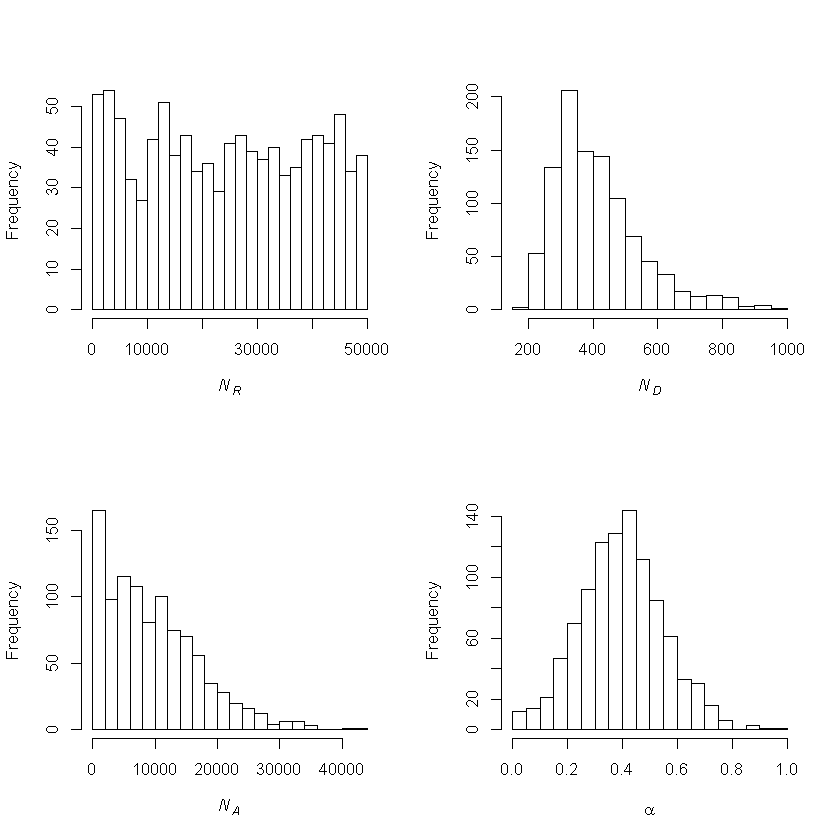

In [24]:
# THEN CALCULATE ANOTHER ROUND OF DISTANCE
temp<-order(result_0910[,4])[1:1000]
posterior_r<-result_0910[temp,1]
posterior_d<-result_0910[temp,2]
posterior_a<-result_0910[temp,3]
max(result_0910[temp,4]) # EPSILON

# POSTERIOR PLOTS
par(mfrow=c(2,2))
hist(posterior_r, breaks=25, xlab=expression(italic(N['R'])), main='')
hist(posterior_d, breaks=25, xlab=expression(italic(N['D'])), main='')
hist(posterior_a, breaks=25, xlab=expression(italic(N['A'])), main='')
hist(posterior_a/posterior_r, breaks=25, xlab=expression(italic(alpha)), main='')

In [26]:
# POSTERIOR N_D
median(posterior_d)
quantile(posterior_d, c(0.1, 0.9))

[1] 383

10%   90% 
270.0 592.1

In [28]:
# POSTERIOR ALPHA
median(posterior_a/posterior_r)
quantile(posterior_a/posterior_r, c(0.1, 0.9))

[1] 0.3979539

10%       90% 
0.2048835 0.5913662